In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # ignore Future deprecation warning
import os
import pickle
from pingouin import anova
from scipy.stats import levene
from scipy.stats import ttest_ind
from scipy.stats import kruskal
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from classes import boundaries as bd
from classes import functions as fcy
from classes import snag_MTF_func as sg

plot_setup = bd.plot_setup()
params = {'mathtext.default':'regular'}
plt.rcParams.update(params)

%matplotlib inline
%config Completer.use_jedi = False 




#--- Notebook run settings
climate_data_list  = ['CRUclim','CRUNCEPv7','CHELSA30s','WorldClim30s','WorldClim10m',]
climate_data       = climate_data_list[1]
level_option_list = ['Site', 'Species']
level_option      = level_option_list[1]    
remove_data       = True

/Users/antje/opt/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/antje/opt/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
#---------------#
#  Import data  #
#---------------#


#--- Site MTF
site_mtf = sg.MTF_database_import('data/MTF_database.xlsx','Site_MTF')
site_mtf.loc[site_mtf['Site name'].isna(),'Site name'] = ''
site_mtf.loc[site_mtf['Y coords'].isna(),'Y coords'] = ''
site_mtf.loc[site_mtf['X coords'].isna(),'X coords'] = ''
site_mtf_cp = site_mtf.copy()

# Select data
#site_mtf = site_mtf[site_mtf['MTF basis'] == 'count']

#--- Species
species_mtf = sg.MTF_database_import('data/MTF_database.xlsx','Species_MTF')
species_mtf.loc[species_mtf['Site name'].isna(),'Site name'] = ''
species_mtf.loc[species_mtf['Y coords'].isna(),'Y coords'] = ''
species_mtf.loc[species_mtf['X coords'].isna(),'X coords'] = ''
species_mtf_cp = species_mtf.copy()

# Select data
#species_mtf = species_mtf[species_mtf['MTF basis'] == 'count']

In [4]:
#---------------#
#  Import data  #
#---------------#

data = []
data = [site_mtf, species_mtf]
    
#--------------------#
#   Transform data   #
#--------------------#

for i,mtf in enumerate(data):
    print(len(mtf))
    if remove_data:    
        mtf = mtf[~(mtf.Reference == 'Ritchie2014EstablishmentForest')].copy()
        mtf = mtf[~(mtf.Reference == 'Campbell2016CarbonStates')].copy()

    mtf.loc[:, 'MTF']           = mtf.loc[:, 'MTF'].apply(np.log) # necessary to fullfill normality of the residuals requirement of multiple regression and ANCOVA
    
    data[i] = mtf
    print(len(mtf))

222
218
332
322



#----------#
#   Site   #
#----------#


#-------------#
#   Species   #
#-------------#



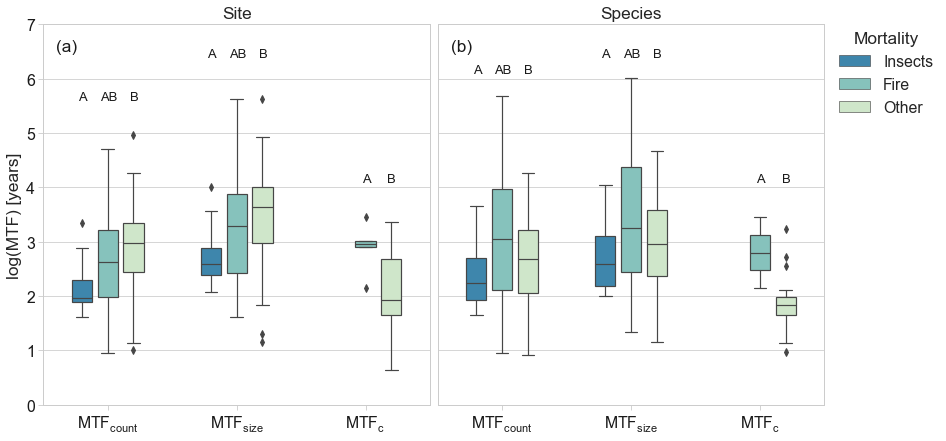

In [5]:

fac = 0.8
sns.set_context("paper", font_scale=1.8)
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left']   = True
plt.rcParams['xtick.color']  = 'lightgrey'
plt.rcParams['ytick.color']  = 'lightgrey'
fig, ax = plt.subplots(1,2, figsize=(14,7),sharey=True)

for i,mtf in enumerate(data):
    bd.print_header(level_option_list[i])

    data[i] = mtf

    g = sns.boxplot(data=mtf, 
                    hue='Mortality', 
                    y='MTF', 
                    x='MTF basis', 
                    width=0.6, 
                    palette=sns.color_palette("GnBu_r",3),
                    hue_order=['Insects', 'Fire', 'Other'],
                    ax=ax[i])
    
    ax[0].legend([],[], frameon=False)
    ax[0].set_ylabel(None)
    
    #--- Annotate signficance letters
    if i == 1:
        height1 = 6.1
    else:
        height1 = 5.6
    ax[i].annotate(xy=(-0.23,height1),text='A',color='k',fontsize=13)
    ax[i].annotate(xy=(0.17,height1),text='B',color='k',fontsize=13)
    ax[i].annotate(xy=(-0.06,height1),text='AB',color='k',fontsize=13)

    height = 6.4
    ax[i].annotate(xy=(0.77,height),text='A',color='k',fontsize=13)
    ax[i].annotate(xy=(0.94,height),text='AB',color='k',fontsize=13)
    ax[i].annotate(xy=(1.17,height),text='B',color='k',fontsize=13)

    height2 = 4.1
    ax[i].annotate(xy=(1.97,height2),text='A',color='k',fontsize=13)
    ax[i].annotate(xy=(2.17,height2),text='B',color='k',fontsize=13)
    
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ax[0].set_yticklabels(np.arange(0,8),color='k')
    ax[0].set_xticklabels(['$MTF_{count}$', '$MTF_{size}$', '$MTF_{c}$'], color='k')
    ax[1].set_xticklabels(['$MTF_{count}$', '$MTF_{size}$', '$MTF_{c}$'], color='k')
    ax[1].yaxis.set_ticks_position('none')    
bd.adjust_box_widths(fig, fac)
ax[0].set_ylabel('log(MTF) [years]')
ax[0].set_title('Site')
ax[1].set_title('Species')
ax[1].set_ylabel("")
ax[0].set_xlabel("")
ax[1].set_xlabel("")
plt.subplots_adjust(wspace=0.02)
ax[1].legend(bbox_to_anchor=(1,1.02), loc='upper left', title='Mortality')
ax[0].annotate(xy=(-0.4,6.5),text='(a)',color='k')
ax[1].annotate(xy=(-0.4,6.5),text='(b)',color='k')





leg = ax[1].get_legend()
leg.set_frame_on(False)
plt.ylim(-0,7)
plt.savefig('Appendix_FigureB1_logMTF_by_mortality_site_species.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:


for l,level in enumerate(level_option_list):
    
    bd.print_TITLE(level)
    mtf_type = mtf['MTF basis'].unique()
    
    mtf = data[l]
    print(len(mtf))
    for t in range(len(mtf_type)):
        
        bd.print_title(mtf_type[t])
        #--- Make t-test between groups of data
        alpha=0.05
        mtf = data[0]
        bd.print_header('Insects vs Fire')
        a = mtf[(mtf.Mortality == 'Insects') & (mtf['MTF basis'] == mtf_type[t])].MTF.values
        b = mtf[(mtf.Fire == 1) & (mtf['MTF basis'] == mtf_type[t])].MTF.values
        stat, p = levene(a, b)
        if p > alpha:
            print('Fire & Insects have homogeneity of variances.')
            display(ttest_ind(a,b))
        else:
            display(kruskal(a, b))



        bd.print_header('Insects vs Other')
        a = mtf[(mtf.Mortality == 'Insects') & (mtf['MTF basis'] == mtf_type[t])].MTF.values
        b = mtf[(mtf.Mort_other == 1) & (mtf['MTF basis'] == mtf_type[t])].MTF.values
        stat, p = levene(a, b)
        if p > alpha:
            print('Other & Insects have homogeneity of variances.')
            display(ttest_ind(a,b))
        else:
            display(kruskal(a, b))

        bd.print_header('Fire vs Other')
        a = mtf[(mtf.Fire == 1) & (mtf['MTF basis'] == mtf_type[t])].MTF.values
        b = mtf[(mtf.Mort_other == 1) & (mtf['MTF basis'] == mtf_type[t])].MTF.values
        stat, p = levene(a, b)
        if p > alpha:
            print('Fire & Other have homogeneity of variances.')
            display(ttest_ind(a,b))
        else:
            display(kruskal(a, b))




             Site             


218

|           |
|   count   |
|           |


#---------------------#
#   Insects vs Fire   #
#---------------------#



KruskalResult(statistic=2.499934631070484, pvalue=0.11385102356651358)


#----------------------#
#   Insects vs Other   #
#----------------------#

Other & Insects have homogeneity of variances.


Ttest_indResult(statistic=-3.1394701362728674, pvalue=0.0026809311498867624)


#-------------------#
#   Fire vs Other   #
#-------------------#

Fire & Other have homogeneity of variances.


Ttest_indResult(statistic=-1.2825851912388644, pvalue=0.20399231986295593)


|           |
|   cmass   |
|           |


#---------------------#
#   Insects vs Fire   #
#---------------------#



KruskalResult(statistic=1.2379648858936207, pvalue=0.2658636307050985)


#----------------------#
#   Insects vs Other   #
#----------------------#



KruskalResult(statistic=8.435589216592264, pvalue=0.0036794763823721835)


#-------------------#
#   Fire vs Other   #
#-------------------#

Fire & Other have homogeneity of variances.


Ttest_indResult(statistic=-1.131422730063177, pvalue=0.26185161349523417)


|       |
|   c   |
|       |


#---------------------#
#   Insects vs Fire   #
#---------------------#



/Users/antje/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antje/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KruskalResult(statistic=nan, pvalue=nan)


#----------------------#
#   Insects vs Other   #
#----------------------#



KruskalResult(statistic=nan, pvalue=nan)


#-------------------#
#   Fire vs Other   #
#-------------------#

Fire & Other have homogeneity of variances.


Ttest_indResult(statistic=2.7415846469538225, pvalue=0.008805767396725605)



             Species             


322

|           |
|   count   |
|           |


#---------------------#
#   Insects vs Fire   #
#---------------------#



KruskalResult(statistic=2.499934631070484, pvalue=0.11385102356651358)


#----------------------#
#   Insects vs Other   #
#----------------------#

Other & Insects have homogeneity of variances.


Ttest_indResult(statistic=-3.1394701362728674, pvalue=0.0026809311498867624)


#-------------------#
#   Fire vs Other   #
#-------------------#

Fire & Other have homogeneity of variances.


Ttest_indResult(statistic=-1.2825851912388644, pvalue=0.20399231986295593)


|           |
|   cmass   |
|           |


#---------------------#
#   Insects vs Fire   #
#---------------------#



KruskalResult(statistic=1.2379648858936207, pvalue=0.2658636307050985)


#----------------------#
#   Insects vs Other   #
#----------------------#



KruskalResult(statistic=8.435589216592264, pvalue=0.0036794763823721835)


#-------------------#
#   Fire vs Other   #
#-------------------#

Fire & Other have homogeneity of variances.


Ttest_indResult(statistic=-1.131422730063177, pvalue=0.26185161349523417)


|       |
|   c   |
|       |


#---------------------#
#   Insects vs Fire   #
#---------------------#



KruskalResult(statistic=nan, pvalue=nan)


#----------------------#
#   Insects vs Other   #
#----------------------#



KruskalResult(statistic=nan, pvalue=nan)


#-------------------#
#   Fire vs Other   #
#-------------------#

Fire & Other have homogeneity of variances.


Ttest_indResult(statistic=2.7415846469538225, pvalue=0.008805767396725605)